In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
## SETTINGS

SET_datapath = "data_pp_sample.json"

df = pd.read_json(SET_datapath, orient="columns")
df.head()

In [ ]:
vectorizer_hash = HashingVectorizer(ngram_range=(1,2), n_features=2500)
X1 = vectorizer_hash.fit_transform(df["comment_text"].values.tolist()).toarray()
y1 = df["toxic"].values

In [ ]:
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2500)
X2 = vectorizer_tfidf.fit_transform(df["comment_text"].values.tolist()).toarray()
y2 = df['toxic'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=99)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (62547, 2500)
X_test shape: (15637, 2500)
y_train shape: (62547,)
y_test shape: (15637,)


In [16]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

## Naive Bayes:

--------------------Training Performance---------------------
0.647193310630406
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     40480
           1       0.00      0.00      0.00     22067

    accuracy                           0.65     62547
   macro avg       0.32      0.50      0.39     62547
weighted avg       0.42      0.65      0.51     62547

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6428343032551
              precision    recall  f1-score   support

           0       0.64      1.00      0.78     10052
           1       0.00      0.00      0.00      5585

    accuracy                           0.64     15637
   macro avg       0.32      0.50      0.39     15637
weighted avg       0.41      0.64      0.50     15637



D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packa

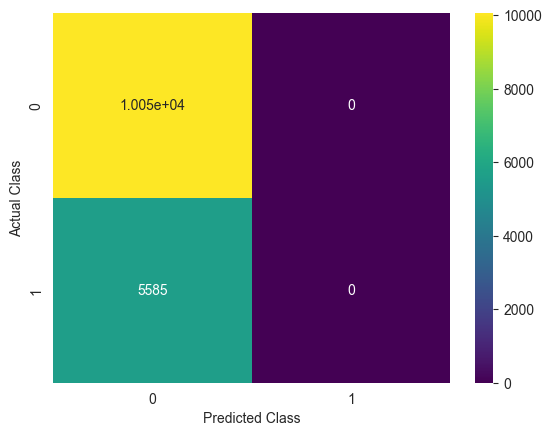

In [27]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

## Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.7224806945177227
              precision    recall  f1-score   support

           0       0.72      0.95      0.82     40480
           1       0.76      0.31      0.44     22067

    accuracy                           0.72     62547
   macro avg       0.74      0.63      0.63     62547
weighted avg       0.73      0.72      0.68     62547

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.698599475602737
              precision    recall  f1-score   support

           0       0.70      0.93      0.80     10052
           1       0.69      0.28      0.40      5585

    accuracy                           0.70     15637
   macro avg       0.69      0.61      0.60     15637
weighted avg       0.70      0.70      0.66     15637



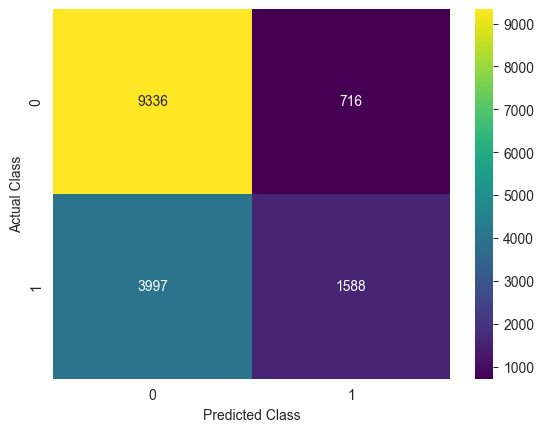

In [28]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

## Random forest:

--------------------Training Performance---------------------
0.6873551089580635
              precision    recall  f1-score   support

           0       0.67      1.00      0.81     40480
           1       0.98      0.12      0.21     22067

    accuracy                           0.69     62547
   macro avg       0.83      0.56      0.51     62547
weighted avg       0.78      0.69      0.59     62547

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6767922235722965
              precision    recall  f1-score   support

           0       0.67      1.00      0.80     10052
           1       0.94      0.10      0.18      5585

    accuracy                           0.68     15637
   macro avg       0.80      0.55      0.49     15637
weighted avg       0.76      0.68      0.58     15637



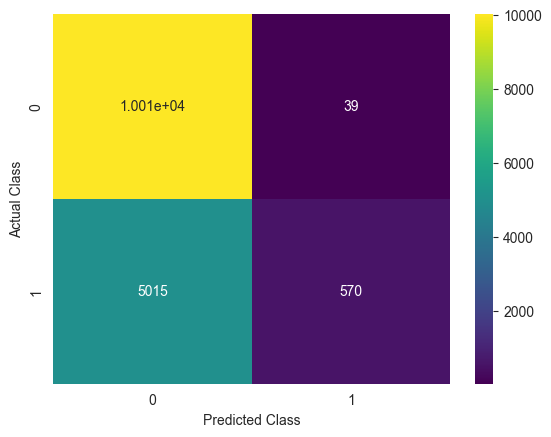

In [29]:
model = RandomForestClassifier(n_estimators=100,max_depth=15,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)